<a href="https://colab.research.google.com/github/gabilodeau/INF6804/blob/master/Segmentation_interactive_avec_SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INF6804 Vision par ordinateur
Polytechnique Montréal <br>
Auteur : Mehdi Miah

Description : ce Jupyter notebook illustre un exemple de segmentation intéractive avec les modèles SAM (Segment Anything model) présenté en 2023 et son successeur SAM 2 en 2024. Une image est d'abord encodée, puis une segmentation est retournée conditionnée par un prompt qui est une indication pour guider la sortie du modèle.

## Installation des librairies


In [1]:
import sys
import torch
import numpy as np
from PIL import Image
from time import time
import matplotlib.pyplot as plt

# SAM
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

# SAM v2
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything-2.git'

# use bfloat16
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()

from segment_anything import SamPredictor, sam_model_registry

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-schtsy2m
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-schtsy2m
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 2418a1deeedaed6dc71295d9c820d7badc9b95a6
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=6a5bc51760b92a375ca25a60b624aef641f909b02b0c4c8eb57b207133b9ed39
  Stored in directory: /tmp/pip-ephem-wheel-cache-mg_woc7c/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything
  Cloning https://github.com/facebookresearch/segment-anything-2.git to /tmp/pip-req-build-kgrcags4
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything-2.git /tmp/pip-req-build-kgrcags4
  Resolved https://github.com/

/usr/local/lib/python3.10/dist-packages/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [2]:
# Some functions for visualization
# Inspired from https://github.com/facebookresearch/segment-anything-2/blob/main/notebooks/video_predictor_example.ipynb

np.random.seed(3)


def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))


def show_masks(image, masks, scores, ax, point_coords=None, box_coords=None, input_labels=None, borders=True, marker_size=375):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        ax.imshow(image)
        show_mask(mask, ax, borders=borders)

        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, ax, marker_size)

        if box_coords is not None:
            show_box(box_coords, ax)

        ax.axis('off')


## Chargement d'une image

Téléchargeons quelques images et affichons en un.

In [3]:
! wget -q https://raw.githubusercontent.com/gabilodeau/INF6804/master/images/baseball.jpg
#! wget -q https://raw.githubusercontent.com/gabilodeau/INF6804/master/images/bicycle.jpg
#! wget -q https://raw.githubusercontent.com/gabilodeau/INF6804/master/images/cats.jpg
#! wget -q https://raw.githubusercontent.com/gabilodeau/INF6804/master/images/city.png

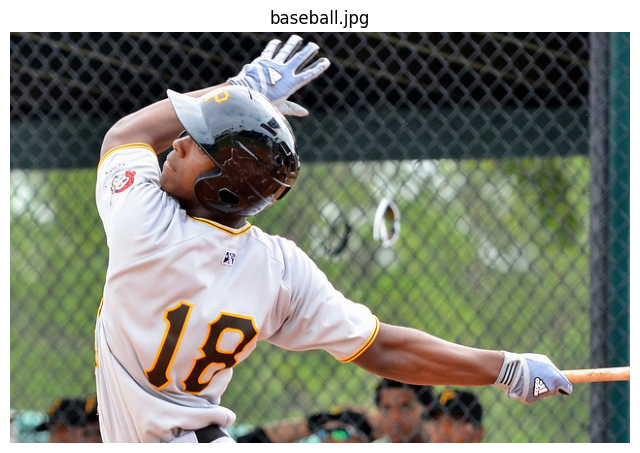

In [4]:
plt.figure(figsize=(8, 8))

filename = 'baseball.jpg'
#filename = 'bicycle.jpg'
#filename = 'cats.jpg'
#"filename = 'city.png'

image = Image.open(filename)
image = np.array(image.convert("RGB"))

plt.imshow(image)
plt.title(f"{filename}")
plt.axis('off')

plt.show()

## Sélection de prompt

Un prompt est une entrée pour guider la sortie de SAM. Ce prompt peut prendre la nature :
- d'une boîte englobante : on souhaite obtenir un masque de segmentation de l'objet compris dans la boîte ;
- de points positifs : on souhaite obtenir un masque de segmentation de l'objet indiqué par ces points ;
- de points négatifs : on souhaite que le masque de segmentation ne corresponde pas à l'objet désigné par ces points.

In [5]:
# Prompts as bounding boxes
box_baseball = np.array([80, 1, 600, 423])
box_bicycle = np.array([320, 420, 1300, 1200])
box_cats = np.array([1480, 380, 2500, 1750])
box_city = np.array([420, 120, 480, 170])

# Prompts as points
point_baseball = np.array([[200, 225]])
point_bicycle = np.array([[725, 875]])
point_cats = np.array([[1990, 1065]])
point_city = np.array([[450, 145]])

# Dictionnary with all prompts
dict_prompts = {'baseball.jpg': {'point': point_baseball, 'box': box_baseball},
                'bicycle.jpg': {'point': point_bicycle, 'box': box_bicycle},
                'cats.jpg': {'point': point_cats, 'box': box_cats},
                'city.png': {'point': point_city, 'box': box_city}
}

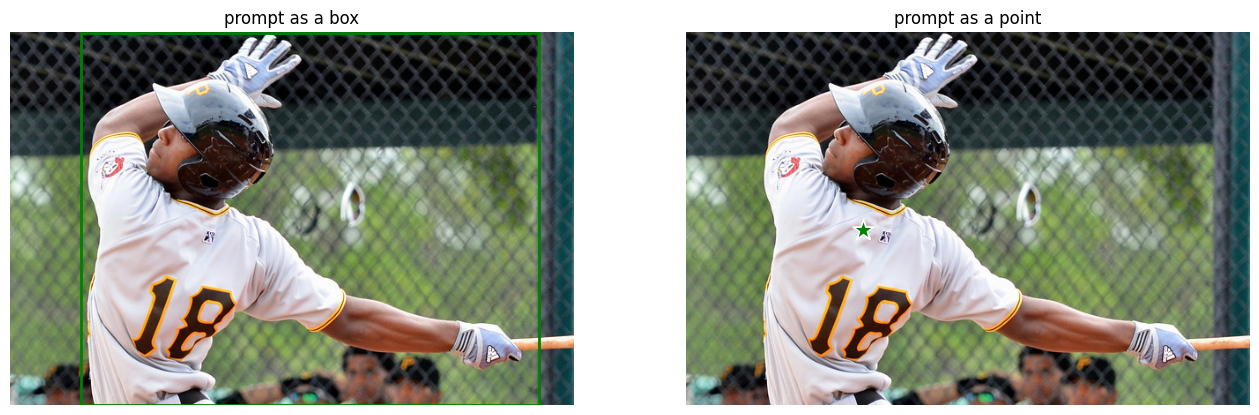

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

image = Image.open(filename)
image = np.array(image.convert("RGB"))

# Display the prompt as a box
show_box(dict_prompts[filename]['box'], ax1)

# Display the prompt as a point
show_points(dict_prompts[filename]['point'], np.array([1]), ax2, marker_size=250)

ax1.imshow(image)
ax2.imshow(image)

ax1.set_title("prompt as a box")
ax2.set_title("prompt as a point")

ax1.axis('off')
ax2.axis('off')

plt.show()

## Chargement d'un modèle SAM

Les poids pré-entraînés disponibles pour SAM sont :
- vit_h (246 Mo);
- vit_b (358 Mo);
- vit_l (1.16 Go)

Les poids pré-entraînés disponibles pour SAM 2 sont :
- tiny (149 Mo) ;
- small (176 Mo);
- base_plus (309 Mo);
- large (856 Mo)

In [7]:
# Downloads weights for SAM
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
#!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
#!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth


--2024-09-18 15:22:35--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.18.87, 13.35.18.102, 13.35.18.103, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.18.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   145MB/s    in 21s     

2024-09-18 15:22:57 (116 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [8]:
sam_model = sam_model_registry['vit_h'](checkpoint='/content/sam_vit_h_4b8939.pth')
#sam_model = sam_model_registry['vit_b'](checkpoint='/content/sam_vit_b_01ec64.pth')
#sam_model = sam_model_registry['vit_l'](checkpoint='/content/sam_vit_l_0b3195.pth')


In [9]:
# Download weights for SAM 2
# ! wgethttps://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt
! wget https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt
# ! wget https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt
# ! wget https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt

--2024-09-18 15:23:04--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.18.87, 13.35.18.102, 13.35.18.103, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.18.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184309650 (176M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2_hiera_small.pt’

sam2_hiera_small.pt 100%[===================>] 175.77M   195MB/s    in 0.9s    

2024-09-18 15:23:05 (195 MB/s) - ‘sam2_hiera_small.pt’ saved [184309650/184309650]



In [10]:
#sam2_model = build_sam2(config_file="sam2_hiera_t.yaml", ckpt_path='sam2_hiera_tiny.pt')
sam2_model = build_sam2(config_file="sam2_hiera_s.yaml", ckpt_path='sam2_hiera_small.pt')
#sam2_model = build_sam2(config_file="sam2_hiera_b+.yaml", ckpt_path='sam2_hiera_base_plus.pt')
#sam2_model = build_sam2(config_file="sam2_hiera_l.yaml", ckpt_path='sam2_hiera_large.pt')

## Prédictions des masques de segmentation à partir des prompts selon SAM et SAM 2

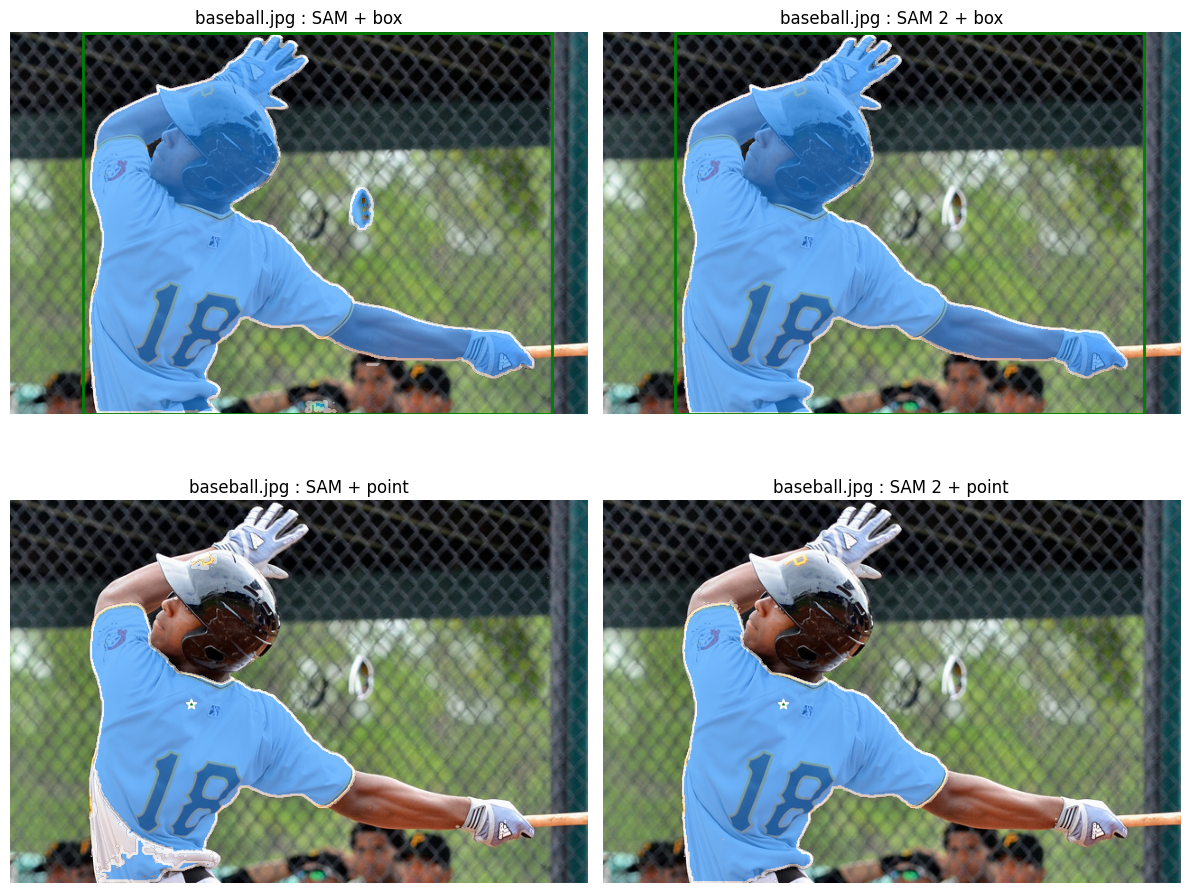

In [11]:
# Predictors
predictor_sam = SamPredictor(sam_model)
predictor_sam2 = SAM2ImagePredictor(sam2_model)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

logs_timer = []

# == Open image ==
image = Image.open(filename)
image = np.array(image.convert("RGB"))

# == SAM model ==

# Encoder with SAM
tic = time()
predictor_sam.set_image(image)
logs_timer.append({'filename': filename, 'model': 'SAM', 'step': 'encoder', 'elapsed_time': time()-tic})

# Decoder on the box
tic = time()
masks, scores, _ = predictor_sam.predict(box=dict_prompts[filename]['box'], multimask_output=False)
logs_timer.append({'filename': filename, 'model': 'SAM', 'step': 'decoder box', 'elapsed_time': time()-tic})

show_masks(image, masks, scores, axes[0, 0], box_coords=dict_prompts[filename]['box'])
axes[0, 0].set_title(f"{filename} : SAM + box")

# Decoder on the point
tic = time()
masks, scores, _ = predictor_sam.predict(point_coords=dict_prompts[filename]['point'], point_labels=np.array([1]), multimask_output=False)
logs_timer.append({'filename': filename, 'model': 'SAM', 'step': 'decoder point', 'elapsed_time': time()-tic})

show_masks(image, masks, scores, axes[1, 0], point_coords=dict_prompts[filename]['point'], input_labels=np.array([1]), marker_size=50)
axes[1, 0].set_title(f"{filename} : SAM + point")

# == SAM 2 ==

# Encoder with SAM 2
tic = time()
predictor_sam2.set_image(image)
logs_timer.append({'filename': filename, 'model': 'SAM 2', 'step': 'encoder', 'elapsed_time': time()-tic})

# Decoder on the box
tic = time()
masks, scores, _ = predictor_sam2.predict(box=dict_prompts[filename]['box'], multimask_output=False)
logs_timer.append({'filename': filename, 'model': 'SAM 2', 'step': 'decoder box', 'elapsed_time': time()-tic})

show_masks(image, masks, scores, axes[0, 1], box_coords=dict_prompts[filename]['box'])
axes[0, 1].set_title(f"{filename} : SAM 2 + box")

# Decoder on the point
tic = time()
masks, scores, _ = predictor_sam2.predict(point_coords=dict_prompts[filename]['point'], point_labels=np.array([1]), multimask_output=False)
logs_timer.append({'filename': filename, 'model': 'SAM 2', 'step': 'decoder point', 'elapsed_time': time()-tic})

show_masks(image, masks, scores, axes[1, 1], point_coords=dict_prompts[filename]['point'], input_labels=np.array([1]), marker_size=50)
axes[1, 1].set_title(f"{filename} : SAM 2 + point")

plt.tight_layout()
plt.show()

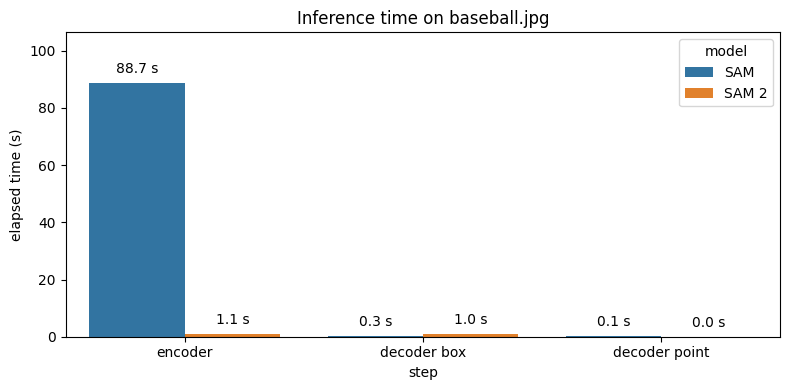

In [12]:
import pandas as pd
import seaborn as sns

# Comparison of inference time between SAM and SAM 2
df_logs = pd.DataFrame(logs_timer)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.barplot(data=df_logs, x='step', y='elapsed_time', hue='model', ax=ax)
ax.set_title(f"Inference time on {filename}")
ax.set_ylabel('elapsed time (s)')

# Annotate each bar
for p in ax.patches:
    if p.get_height() > 0:
      ax.annotate(f'{p.get_height():.1f} s', (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Adjust vertically
max_height = max(p.get_height() for p in ax.patches)
ylim = ax.get_ylim()
ax.set_ylim(ylim[0], max_height * 1.2)

plt.tight_layout()
plt.show()

## Références

Segment Anything model (SAM) : [article](https://arxiv.org/pdf/2304.02643), [page web du projet](https://segment-anything.com/), [démo en ligne](https://segment-anything.com/demo) et [notebook officiel](https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb)

Segment Anything model 2 (SAM 2) : [article](https://arxiv.org/pdf/2408.00714), [page web du projet](https://ai.meta.com/sam2/), [démo en ligne](https://sam2.metademolab.com/) et [notebook officiel](https://github.com/facebookresearch/segment-anything-2/blob/main/notebooks/image_predictor_example.ipynb)